# Convolution for MNIST 1D
This notebook aims to help gain a better understanding of 1D convolution by defining a 1D convolutional neural network and plotting its test and validation error 

### Import
Import the libraries needed to define a 1D convolutional neural network and plots its test and validation error

In [1]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random

### Import Training and Validation Data

In [2]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

Successfully loaded data from ./mnist1d_data.pkl


### Define Array Structures for Training and Validation Data
Separate the imported data into training and validation data and store it in its respective variables

In [3]:
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']

### Print Dimensions of Training and Validation Data

In [4]:
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 4000 examples (columns), each of which has 40 dimensions (rows)


### Define Hyperparameters
Define the hyperparameters (input, output dimensions) of the convolutional neural network

In [5]:
D_i = 40
D_o = 10

### Define Convolutional Neural Network Model (CNN)
Define a convolutional neural network model that undergoes a convolution operation that results in the computation of three different activaiton maps (one for each convolution). Afterwards, flatten the three activation maps and output a layer of 10 units

In [6]:
model = nn.Sequential(
nn.Conv1d(1, 15, 3, 2, padding=0),
nn.ReLU(),
nn.Conv1d(15, 15, 3, 2, padding=0),
nn.ReLU(),
nn.Conv1d(15, 15, 3, 2, padding=0),
nn.ReLU(),
nn.Flatten(),
nn.Linear(60, 10),
)

### Define He Initialization
Define He initialization, which initializes the value of the weights without going through the shrinking or exploding gradient problem

In [7]:
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

### Define Cross Entropy Loss
Define the cross entropy loss function as the loss function for the CNN

In [8]:
loss_function = nn.CrossEntropyLoss()

### Define Stochastic Gradient Descent
Define the stochastic gradient descent (SGD) as the chosen gradient descent step function for the CNN and initalize its learning rate and momentum

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)

### Define Scheduler
Define a scheduler, which is an object that decreases learning rate by half every 20 epochs

In [10]:
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

### Format Training and Validation Data
Convert the training and validation data into proper format for training the CNN

In [11]:
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long')).long()
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long')).long()

### Define Batches
Separate the data into batches for the stochastic gradient descent step function

In [12]:
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

### Initialize CNN Model Weights

In [13]:
model.apply(weights_init)

Sequential(
  (0): Conv1d(1, 15, kernel_size=(3,), stride=(2,))
  (1): ReLU()
  (2): Conv1d(15, 15, kernel_size=(3,), stride=(2,))
  (3): ReLU()
  (4): Conv1d(15, 15, kernel_size=(3,), stride=(2,))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=60, out_features=10, bias=True)
)

### Define Epoch
Define the number of times to loop over the entire dataset

In [14]:
n_epoch = 100

### Define Loss and % Correct Array Structure
Define array structures that store the loss and the % correct of the convolutional neural network model at each epoch

In [15]:
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

### Compute Backpropagation
Undergo backpropagation to update the parameters of the convolutional neural network and calculate the loss and % correct after each backpropagation loop

In [16]:
for epoch in range(n_epoch):
  # Loop over batches
  for i, data in enumerate(data_loader):
    # Retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # Reset the parameter gradients to zero
    optimizer.zero_grad()
    # Calculate forward pass and model output
    pred = model(x_batch[:,None,:])
    # Compute the loss
    loss = loss_function(pred, y_batch)
    # Compute backward pass
    loss.backward()
    # Undergo the SGD 
    optimizer.step()

  # Compute statistics for this epoch
  pred_train = model(x_train[:,None,:])
  pred_val = model(x_val[:,None,:])
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # Update learning rate based on scheduler 
  scheduler.step()

Epoch     0, train loss 2.163822, train error 84.43,  val loss 2.167745, percent error 84.60
Epoch     1, train loss 1.796545, train error 71.07,  val loss 1.795013, percent error 69.78
Epoch     2, train loss 1.492529, train error 59.58,  val loss 1.493612, percent error 60.20
Epoch     3, train loss 1.344039, train error 55.08,  val loss 1.363669, percent error 54.15
Epoch     4, train loss 1.293920, train error 52.50,  val loss 1.315753, percent error 53.15
Epoch     5, train loss 1.218970, train error 51.28,  val loss 1.262989, percent error 53.33
Epoch     6, train loss 1.127585, train error 45.42,  val loss 1.184062, percent error 48.42
Epoch     7, train loss 1.040591, train error 40.17,  val loss 1.090231, percent error 43.47
Epoch     8, train loss 0.903223, train error 36.30,  val loss 0.964628, percent error 39.03
Epoch     9, train loss 0.901053, train error 34.25,  val loss 0.936940, percent error 36.47
Epoch    10, train loss 0.820674, train error 32.65,  val loss 0.87470

### Plot Training and Validation Error of CNN

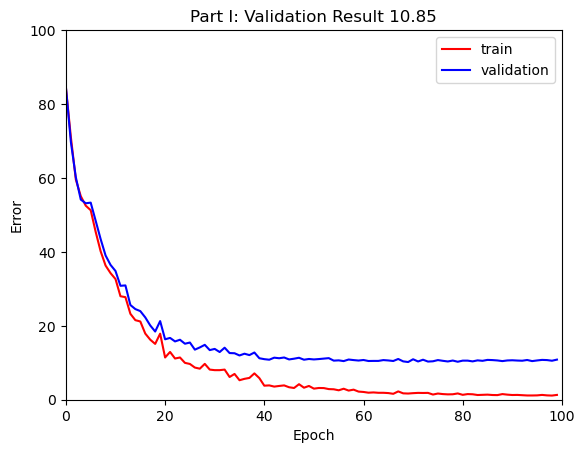

In [17]:
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='validation')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Part I: Validation Result %3.2f'%(errors_val[-1]))
ax.legend()
plt.show()